# Project 2 NLP: Hatespeech Classifier

## Authors:

Adrian Obermühlner & Freja Rasmussen

## Resarch Question:

How do different preprocessing methods (nothing, stop word removal, lemming, stemming,…) affect the result of a hate speech classifier?

## Imports

In [98]:
# Imports
import pandas as pd
import numpy as np
import torch
import regex as re
import matplotlib.pyplot as plt

# Preprocessing imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Tokenizing
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [99]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce GTX 1650 Ti


## Data Import


In [100]:
RANDOM_SEED = 42
BINARY_LABEL = "is_hate"
CATEGORIES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

np.random.seed(RANDOM_SEED)  # set random seed for reproducibility
# Make the labels into hate and no hate as 1 and 0

def binarize_labels(df):
    return (df[CATEGORIES].sum(axis=1) > 0).astype(int)

data_train = pd.read_csv("./data/train/train.csv", index_col=0)
data_train[BINARY_LABEL] = binarize_labels(data_train)

data_test = pd.read_csv("./data/test/test.csv", index_col=0).join(
    pd.read_csv("./data/test_labels/test_labels.csv", index_col=0)
)
data_test.drop(data_test[data_test["toxic"] == -1].index, inplace=True)
data_test[BINARY_LABEL] = binarize_labels(data_test)

In [101]:
data_train['comment_text'].head(10)

id
0000997932d777bf    Explanation\nWhy the edits made under my usern...
000103f0d9cfb60f    D'aww! He matches this background colour I'm s...
000113f07ec002fd    Hey man, I'm really not trying to edit war. It...
0001b41b1c6bb37e    "\nMore\nI can't make any real suggestions on ...
0001d958c54c6e35    You, sir, are my hero. Any chance you remember...
00025465d4725e87    "\n\nCongratulations from me as well, use the ...
0002bcb3da6cb337         COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
00031b1e95af7921    Your vandalism to the Matt Shirvington article...
00037261f536c51d    Sorry if the word 'nonsense' was offensive to ...
00040093b2687caa    alignment on this subject and which are contra...
Name: comment_text, dtype: object

In [102]:
data_test.head(10)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_hate
id,,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,0
000663aff0fffc80,this other one from 1897,0,0,0,0,0,0,0
000689dd34e20979,== Reason for banning throwing == \n\n This ar...,0,0,0,0,0,0,0
000844b52dee5f3f,|blocked]] from editing Wikipedia. |,0,0,0,0,0,0,0
00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0,1


In [103]:
# get the distribution of the labels to see if roughly similar for both

is_hate_count_train = data_train['is_hate'].value_counts()
ratio_train = is_hate_count_train/ len(data_train)

is_hate_count_test = data_test['is_hate'].value_counts()
ratio_test = is_hate_count_test/ len(data_test)

print('Ratio of no/is hate for train set: ', ratio_train)
print('Ratio of no/is hate for test set: ', ratio_test)

Ratio of no/is hate for train set:  0    0.898321
1    0.101679
Name: is_hate, dtype: float64
Ratio of no/is hate for test set:  0    0.90242
1    0.09758
Name: is_hate, dtype: float64


## Representation

## Data Preprocessing

**Note**: We would need to make a loop for the different combinations of 
preprocessing (none, only stemming, only lemming, only stop word removal and every combination of this)
Either as coloumns that can be used to iterate over for the model training and validation, or make the preprocessing
and then go further and repeat from beginning.


In [104]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def handle_negations(tokens):
    negation_words = {'not', "n't", 'no', 'never', 'none'}
    processed_tokens = []
    skip_next = False

    for i, word in enumerate(tokens):
        if skip_next:
            skip_next = False
            continue

        if word in negation_words and i + 1 < len(tokens):
            processed_tokens.append(word + '_' + tokens[i + 1])
            skip_next = True
        else:
            processed_tokens.append(word)

    return processed_tokens

import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


# Assuming stop_words is defined somewhere

def get_wordnet_pos(treebank_tag):
    """Converts treebank tags to wordnet tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def preprocess_text(text, use_lower=False, remove_stopwords=False, use_stemming=False, use_lemming=False, combine_negations=False, keep_semantic_punctuation=False):
    if use_lower:
        text = text.lower()
    
    tokens = word_tokenize(text)
    
    if combine_negations:
        tokens = handle_negations(tokens)

    if remove_stopwords:
        tokens = [word for word in tokens if word.lower() not in stop_words]
    
    if not keep_semantic_punctuation:
        tokens = [re.sub(r'[^\w\s]', '', word) for word in tokens]
    
    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    elif use_lemming:
        lemmatizer = WordNetLemmatizer()
        tagged_tokens = pos_tag(tokens)
        tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    
    filtered_tokens = [word for word in tokens if word.isalpha()]

    return ' '.join(filtered_tokens)


# Apply the preprocessing function to the training and test datasets
# We don't pass the rare_words parameter, so rare word removal is not performed
#data_train['comment_text_clean_2'] = data_train['comment_text'].apply(lambda x: preprocess_text(x, use_stemming=False))
#data_test['comment_text_clean_2'] = data_test['comment_text'].apply(lambda x: preprocess_text(x, use_stemming=False))



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\flras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flras\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flras\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\flras\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [105]:
data_train.shape

(159571, 8)

In [106]:
# Keeping semantic punctuation (keeping ! and ?)
data_train['text_no_punctuation'] = data_train['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=True, keep_semantic_punctuation=False))
data_train['text_with_punctuation'] = data_train['text_no_punctuation'].apply(lambda x: preprocess_text(x, keep_semantic_punctuation=True,))


In [107]:
# Keeping semantic punctuation (keeping ! and ?)
data_test['text_no_punctuation'] = data_test['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=True, keep_semantic_punctuation=False))
data_test['text_with_punctuation'] = data_test['text_no_punctuation'].apply(lambda x: preprocess_text(x, keep_semantic_punctuation=True,))


In [108]:
data_train.to_csv('train_all_coloumns.csv')

In [109]:
data_test.to_csv('test_all_coloumns.csv')

In [110]:
# Keep negations
data_train['text_without_negations'] = data_train['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=True, keep_semantic_punctuation=False, use_lemming=True, combine_negations=False))
data_train['text_with_negations'] = data_train['text_without_negations'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_lemming=False, combine_negations=True))

data_train.to_csv('train_all_coloumns.csv')

In [111]:
# Keep negations
data_test['text_without_negations'] = data_test['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=True, keep_semantic_punctuation=False, use_lemming=True, combine_negations=False))
data_test['text_with_negations'] = data_test['text_without_negations'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_lemming=False, combine_negations=True))

data_test.to_csv('test_all_coloumns.csv')

In [112]:
# 5 Steps of Processing
# Only lowercase
data_train['data_text_1'] = data_train['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=False, keep_semantic_punctuation=True, use_stemming=False))
data_train.to_csv('train_all_coloumns.csv')

In [113]:
# 5 Steps of Processing
# Only lowercase
data_test['data_text_1'] = data_test['comment_text'].apply(lambda x: preprocess_text(x, use_lower=True, remove_stopwords=False, keep_semantic_punctuation=True, use_stemming=False))
data_test.to_csv('test_all_coloumns.csv')

In [114]:

# Lowercase and stopwords removal
data_train['data_text_2'] = data_train['data_text_1'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=True, keep_semantic_punctuation=False, use_stemming=False))
data_train.to_csv('train_all_coloumns.csv')

In [115]:

# Lowercase and stopwords removal
data_test['data_text_2'] = data_test['data_text_1'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=True, keep_semantic_punctuation=False, use_stemming=False))
data_test.to_csv('test_all_coloumns.csv')

In [116]:

# Add punctuation handling
data_train['data_text_3'] = data_train['data_text_2'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=True, use_stemming=False))
data_train.to_csv('train_all_coloumns.csv')

In [117]:

# Add punctuation handling
data_test['data_text_3'] = data_test['data_text_2'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=True, use_stemming=False))
data_test.to_csv('test_all_coloumns.csv')

In [118]:

# Incorporate lemmatization
data_train['data_text_4'] = data_train['data_text_3'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, combine_negations=True))
data_train.to_csv('train_all_coloumns.csv')

In [119]:

# Incorporate lemmatization
data_test['data_text_4'] = data_test['data_text_3'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, combine_negations=True))
data_test.to_csv('test_all_coloumns.csv')

In [17]:

# Incorporate stemming or lemming, depends on which was is more efficent
data_train['data_text_5_stemming'] = data_train['data_text_4'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_stemming=True, combine_negations=False))
data_train.to_csv('train_all_coloumns.csv')

: 

In [ ]:

# Incorporate stemming or lemming, depends on which was is more efficent
data_test['data_text_5_stemming'] = data_test['data_text_4'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_stemming=True, combine_negations=False))
data_test.to_csv('train_all_coloumns.csv')

In [ ]:
data_train['data_text_5_lemming'] = data_train['data_text_4'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_lemming=True, combine_negations=False))
data_train.to_csv('train_all_coloumns.csv')

In [ ]:
data_test['data_text_5_lemming'] = data_test['data_text_4'].apply(lambda x: preprocess_text(x, use_lower=False, remove_stopwords=False, keep_semantic_punctuation=False, use_lemming=True, combine_negations=False))
data_test.to_csv('train_all_coloumns.csv')

In [90]:
data_train = pd.read_csv("./train_all_coloumns.csv", index_col=0)

data_test = pd.read_csv("./test_all_coloumns.csv", index_col=0)
data_train.head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_hate,text_with_punctuation,text_without_negations,...,yes,yesterday,yet,york,you,youi,young,yourselfgo,youtube,zero
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.352046,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
data_test.to_csv('test_all_coloumns.csv')
data_train.to_csv('train_all_coloumns.csv')

In [ ]:

data_test.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_hate,text_no_punctuation,text_with_punctuation,text_without_negations,text_with_negations,data_text_1,data_text_2,data_text_3,data_text_4
id,,,,,,,,,,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,thank understanding think highly would revert ...,thank understanding think highly would revert ...,thank understand think highly would revert wit...,thank understand think highly would revert wit...,thank you for understanding i think very highl...,thank understanding think highly would revert ...,thank understanding think highly would revert ...,thank understanding think highly would revert ...
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,0,dear god site horrible,dear god site horrible,dear god site horrible,dear god site horrible,dear god this site is horrible,dear god site horrible,dear god site horrible,dear god site horrible
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,0,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody will invariably try to add religion r...,somebody invariably try add religion really me...,somebody invariably try add religion really me...,somebody invariably try add religion really me...
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,0,says right type type institution needed case t...,says right type type institution needed case t...,say right type type institution need case thre...,say right type type institution need case thre...,it says it right there that it is a type the t...,says right type type institution needed case t...,says right type type institution needed case t...,says right type type institution needed case t...
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,0,adding new product list make sure s relevant a...,adding new product list make sure s relevant a...,add new product list make sure s relevant add ...,add new product list make sure s relevant add ...,before adding a new product to the list make s...,adding new product list make sure relevant add...,adding new product list make sure relevant add...,adding new product list make sure relevant add...


In [121]:
print(data_train.isna().sum())
print(data_test.isna().sum())

comment_text              0
toxic                     0
severe_toxic              0
obscene                   0
threat                    0
insult                    0
identity_hate             0
is_hate                   0
text_no_punctuation       0
text_with_punctuation     0
text_without_negations    0
text_with_negations       0
data_text_1               0
data_text_2               0
data_text_3               0
data_text_4               0
dtype: int64
comment_text              0
toxic                     0
severe_toxic              0
obscene                   0
threat                    0
insult                    0
identity_hate             0
is_hate                   0
text_no_punctuation       0
text_with_punctuation     0
text_without_negations    0
text_with_negations       0
data_text_1               0
data_text_2               0
data_text_3               0
data_text_4               0
dtype: int64


In [122]:
data_train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_hate,text_no_punctuation,text_with_punctuation,text_without_negations,text_with_negations,data_text_1,data_text_2,data_text_3,data_text_4
id,,,,,,,,,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...,explanation edits make username hardcore metal...,explanation edits make username hardcore metal...,explanation why the edits made under my userna...,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww matches background colour m seemingly stu...,daww matches background colour m seemingly stu...,daww match background colour m seemingly stuck...,daww match background colour m seemingly stuck...,he matches this background colour i seemingly ...,matches background colour seemingly stuck than...,matches background colour seemingly stuck than...,matches background colour seemingly stuck than...
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man m really trying edit war s guy constan...,hey man m really trying edit war s guy constan...,hey man m really try edit war s guy constantly...,hey man m really try edit war s guy constantly...,hey man i really not trying to edit war it jus...,hey man really trying edit war guy constantly ...,hey man really trying edit war guy constantly ...,hey man really trying edit war guy constantly ...
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,ca nt make real suggestions improvement wonder...,ca nt make real suggestions improvement wonder...,ca nt make real suggestion improvement wonder ...,ca nt make real suggestion improvement wonder ...,more i ca make any real suggestions on improve...,ca make real suggestions improvement wondered ...,ca make real suggestions improvement wondered ...,ca make real suggestions improvement wondered ...
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,sir hero chance remember page s,sir hero chance remember page s,sir hero chance remember page s,sir hero chance remember page s,you sir are my hero any chance you remember wh...,sir hero chance remember page,sir hero chance remember page,sir hero chance remember page


In [124]:
# Train and Test set undersample test set
# Define test and train set
def datasetDefinition(columnName):
    X_train = data_train[columnName]
    y_train = data_train["is_hate"]

    X_test = data_test[columnName]
    y_test = data_test["is_hate"]
    return X_train, y_train, X_test, y_test


## Word Embedding



**Notes**: Tokenizing with TF-IDF

In [81]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000)



In [94]:
print(data_test.shape)
data_test.dropna(inplace=True)
print(data_test.shape)


(63978, 16)
(63720, 16)


In [97]:
data_test['text_no_punctuation'].shape

(63720,)

In [130]:
from sklearn.model_selection import train_test_split


def makeToTensors(X_train, y_train, X_test, y_test):
    # Make the test and train sets to tensors and apply TF-IDF
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

    # Transform testing data
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    # Convert TF-IDF matrices to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    X_train, X_test, y_train, y_test = train_test_split(X_train_tensor, y_train_tensor, test_size=0.8, stratify=y_train, random_state=42)


    return X_train, y_train, X_test_tensor, y_test_tensor

## Model Implementation & Test with Testset

**Note**: Does a CNN makes sense for sentiment analysis? or a simpler model?

**Answers and additional Notes**:
Make a CNN with PyTorch using skorch as wrapper to make it possible to use sklearn.pipeline with the model
This way gridsearch for hyper parameters is possible and tfidfVectorizer can be used for tf-idf
CNN: vector size 300, conv. layer of some size, flatten, relu, end with softmax or something
Example: https://www.kaggle.com/code/raviusz/jigsaw-toxic-comment
example look very good to get basics and then change some of architecture
hyperparameter tuning for each model? only if time permits, alt. tune on best model and use for rest

**Note**: We will use the given test set to compare the different approaches. Make a dataframe with all the results
in accuracy, f1, recall, etc. 

In [131]:

# CNN: The basic model

class CNN(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv_output_size = self._get_conv_output_size(2000)
        
        self.fc1 = nn.Linear(self.conv_output_size, 64)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        
    def _get_conv_output_size(self, input_size):
        x = torch.randn(1, 1, input_size)  # Add channel dimension
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        return x.view(1, -1).size(1)


batchSize = 25

def trainCNN(X_train, y_train, X_test, y_test,  batch_size=batchSize, epochs=7, learning_rate=0.001):

    # Step 4: Train the model
    train_dataset = TensorDataset(X_train, y_train)  # Assuming X_train_tensor and y_train_tensor are tensors
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    train_loss = []
    train_accuracy = []
    # Move model to GPU
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print(f'learning rate: {learning_rate}, total number of epochs: {epochs}')
    for epoch in range(int(epochs)):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        epoch_accuracy = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = total_loss / len(train_dataset)
        epoch_accuracy = correct / total
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')

    # Step 5: Evaluate the model
    # Assuming X_test_tensor and y_test_tensor are tensors
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model.eval()
    total_correct = 0
    total_predicted = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += torch.sum(predicted == labels).item()
            total_predicted += len(predicted)
    # Calculate evaluation metrics
    accuracy = total_correct / total_predicted
    
    print(f'Test Accuracy: {accuracy}')
    return accuracy, model, train_loss, train_accuracy


learning rate: 0.0001, total number of epochs: 10
Epoch [1/10], Loss: 0.3227211402844365, Accuracy: 0.8983204863069499
Epoch [2/10], Loss: 0.23482429818978337, Accuracy: 0.8983204863069499
Epoch [3/10], Loss: 0.21763199174347928, Accuracy: 0.9141755969167137
Epoch [4/10], Loss: 0.20242354045806774, Accuracy: 0.9256439180297048
Epoch [5/10], Loss: 0.18996399956357118, Accuracy: 0.9353575233439869
Epoch [6/10], Loss: 0.18151348399105421, Accuracy: 0.9393683023124647
Epoch [7/10], Loss: 0.17198552398950523, Accuracy: 0.9422823839067493
Epoch [8/10], Loss: 0.16558182034588392, Accuracy: 0.9435984207557812
Epoch [9/10], Loss: 0.15766462954351868, Accuracy: 0.9460111549790061
Epoch [10/10], Loss: 0.15079328141950232, Accuracy: 0.9492699128908942
Test Accuracy: 0.9224577198411954


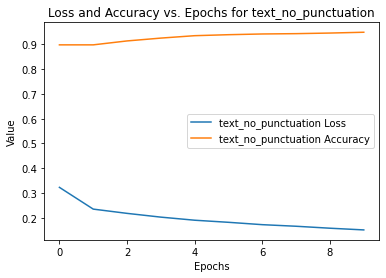

learning rate: 0.0001, total number of epochs: 10
Epoch [1/10], Loss: 0.3202118016856464, Accuracy: 0.8980071442000376
Epoch [2/10], Loss: 0.23677259270224818, Accuracy: 0.9168390048254684
Epoch [3/10], Loss: 0.22064615755294145, Accuracy: 0.9267719496145892
Epoch [4/10], Loss: 0.20466727572340632, Accuracy: 0.9309393996365232
Epoch [5/10], Loss: 0.19437288572486358, Accuracy: 0.9341668233377202
Epoch [6/10], Loss: 0.18748107792435723, Accuracy: 0.9366422259823275
Epoch [7/10], Loss: 0.1798810258465356, Accuracy: 0.9403709970545842
Epoch [8/10], Loss: 0.17481444106786462, Accuracy: 0.9422197154853669
Epoch [9/10], Loss: 0.16737924087490308, Accuracy: 0.9446637839192831
Epoch [10/10], Loss: 0.16208304880693403, Accuracy: 0.9454158049758726
Test Accuracy: 0.9217856138047453


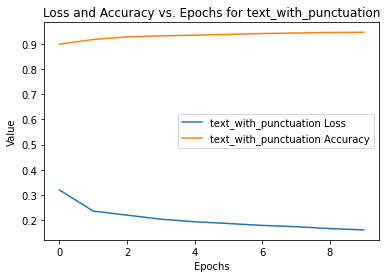

learning rate: 0.0001, total number of epochs: 10
Epoch [1/10], Loss: 0.3130788021342919, Accuracy: 0.8984144889390236
Epoch [2/10], Loss: 0.2385937965615623, Accuracy: 0.9176850285141317
Epoch [3/10], Loss: 0.21864219780293692, Accuracy: 0.9267719496145892
Epoch [4/10], Loss: 0.20046434305692784, Accuracy: 0.9332267970169832
Epoch [5/10], Loss: 0.1845274353375068, Accuracy: 0.9377389233565206
Epoch [6/10], Loss: 0.17592477650361957, Accuracy: 0.9414990286394685
Epoch [7/10], Loss: 0.16849176626908816, Accuracy: 0.9438177602306198
Epoch [8/10], Loss: 0.16003679977408328, Accuracy: 0.9461364918217711
Epoch [9/10], Loss: 0.15427916028021557, Accuracy: 0.9491445760481293
Epoch [10/10], Loss: 0.14878206618901552, Accuracy: 0.9493012471015855
Test Accuracy: 0.927146831723405


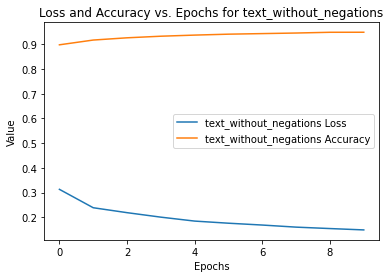

learning rate: 0.0001, total number of epochs: 10
Epoch [1/10], Loss: 0.3229594826386637, Accuracy: 0.8983204863069499
Epoch [2/10], Loss: 0.2364450690000988, Accuracy: 0.8983204863069499
Epoch [3/10], Loss: 0.22180521648674606, Accuracy: 0.8983204863069499
Epoch [4/10], Loss: 0.20848758814291676, Accuracy: 0.9018925863257504
Epoch [5/10], Loss: 0.1970624699421727, Accuracy: 0.9342608259697939
Epoch [6/10], Loss: 0.17978941680802918, Accuracy: 0.9402143260011281
Epoch [7/10], Loss: 0.1701540045858437, Accuracy: 0.9424077207495143
Epoch [8/10], Loss: 0.1594112919750445, Accuracy: 0.9455098076079463
Epoch [9/10], Loss: 0.1530582625051205, Accuracy: 0.9491445760481293
Epoch [10/10], Loss: 0.14527830417958607, Accuracy: 0.9503039418437049
Test Accuracy: 0.9252399262246397


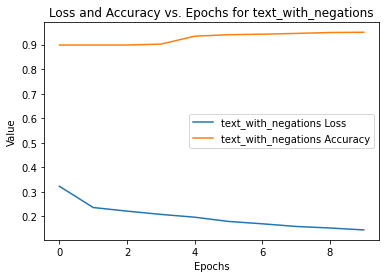

learning rate: 0.0001, total number of epochs: 10
Epoch [1/10], Loss: 0.32215962434108036, Accuracy: 0.89806981262142
Epoch [2/10], Loss: 0.23450935509419113, Accuracy: 0.8983204863069499
Epoch [3/10], Loss: 0.22006163838171058, Accuracy: 0.910728833740678
Epoch [4/10], Loss: 0.21140156439038893, Accuracy: 0.928369994359842
Epoch [5/10], Loss: 0.20121186369284264, Accuracy: 0.9323494391176286
Epoch [6/10], Loss: 0.18890956500951944, Accuracy: 0.9362662154540327
Epoch [7/10], Loss: 0.18002003028698416, Accuracy: 0.9394309707338472
Epoch [8/10], Loss: 0.17065075332657934, Accuracy: 0.9414050260073948
Epoch [9/10], Loss: 0.16456762539130504, Accuracy: 0.943441749702325
Epoch [10/10], Loss: 0.15968542304973818, Accuracy: 0.9458544839255499
Test Accuracy: 0.9266466597893026


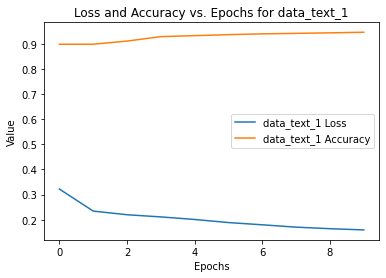

learning rate: 0.0001, total number of epochs: 10
Epoch [1/10], Loss: 0.3099802920543801, Accuracy: 0.9000438678949677
Epoch [2/10], Loss: 0.23041157836561765, Accuracy: 0.9120135363790186
Epoch [3/10], Loss: 0.21244949016378273, Accuracy: 0.9268659522466629
Epoch [4/10], Loss: 0.19820669289674134, Accuracy: 0.9320360970107163
Epoch [5/10], Loss: 0.1873873457323498, Accuracy: 0.9352635207119133
Epoch [6/10], Loss: 0.1797466086684918, Accuracy: 0.9395876417873034
Epoch [7/10], Loss: 0.17412592208641758, Accuracy: 0.9414363602180861
Epoch [8/10], Loss: 0.16827521277000354, Accuracy: 0.9431284075954127
Epoch [9/10], Loss: 0.16173961060731565, Accuracy: 0.944789120762048
Epoch [10/10], Loss: 0.15298701274770365, Accuracy: 0.948298552359466
Test Accuracy: 0.9256306855481572


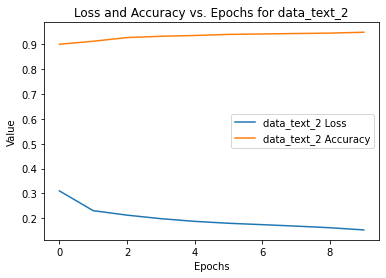

learning rate: 0.0001, total number of epochs: 10
Epoch [1/10], Loss: 0.30501722126786884, Accuracy: 0.9015479100081469
Epoch [2/10], Loss: 0.22765769011933376, Accuracy: 0.9228238390674939
Epoch [3/10], Loss: 0.21327126185150178, Accuracy: 0.9274926364604875
Epoch [4/10], Loss: 0.2006721075836324, Accuracy: 0.9326627812245409
Epoch [5/10], Loss: 0.1915891811621321, Accuracy: 0.9359842075578116
Epoch [6/10], Loss: 0.18394549958398074, Accuracy: 0.9387416180986401
Epoch [7/10], Loss: 0.1751292833978211, Accuracy: 0.9413736917967036
Epoch [8/10], Loss: 0.16909079225740295, Accuracy: 0.9431910760167951
Epoch [9/10], Loss: 0.1605947803060536, Accuracy: 0.9459798207683149
Epoch [10/10], Loss: 0.15355397870572934, Accuracy: 0.9482672181487748
Test Accuracy: 0.9202694676294977


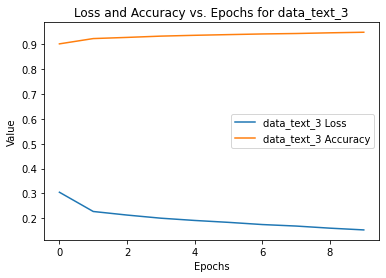

learning rate: 0.0001, total number of epochs: 10
Epoch [1/10], Loss: 0.33924984117772483, Accuracy: 0.8973491257755217
Epoch [2/10], Loss: 0.24664478586771763, Accuracy: 0.9142069311274049
Epoch [3/10], Loss: 0.22868930740332016, Accuracy: 0.9251112364479539
Epoch [4/10], Loss: 0.21919362203158452, Accuracy: 0.9286833364667544
Epoch [5/10], Loss: 0.20894397549719196, Accuracy: 0.9309393996365232
Epoch [6/10], Loss: 0.20054488400903286, Accuracy: 0.9341981575484114
Epoch [7/10], Loss: 0.19105838170912315, Accuracy: 0.9364542207181801
Epoch [8/10], Loss: 0.183726940647983, Accuracy: 0.939399636523156
Epoch [9/10], Loss: 0.1749546256573775, Accuracy: 0.9412796891646299
Epoch [10/10], Loss: 0.1703839688990544, Accuracy: 0.9441624365482234
Test Accuracy: 0.9237706711682141


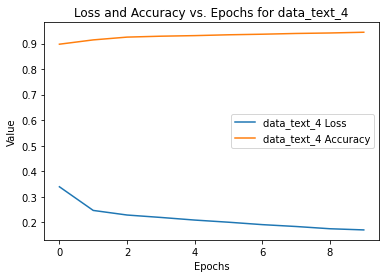

In [132]:
# for all the columns load them into X_train
# make the tensors, train the cnn and thenn take the outcome and add it to a df
columnName = ['text_no_punctuation', 'text_with_punctuation', 'text_without_negations', 'text_with_negations', 
              'data_text_1', 'data_text_2', 'data_text_3', 'data_text_4']

results = []
all_train_loss = []
all_train_accuracy = []
for name in columnName:
    X_train, y_train, X_test, y_test = datasetDefinition(name)
    X_train_T, y_train_T, X_test_T, y_test_T = makeToTensors(X_train, y_train, X_test, y_test)
    
    # Get the test accuracy using the best model
    accuracy, model, train_loss, train_accuracy = trainCNN(X_train_T, y_train_T, X_test_T, y_test_T, epochs=10, learning_rate=0.0001)
    
    all_train_loss.append(train_loss)
    all_train_accuracy.append(train_accuracy)

    plt.plot(train_loss, label=f'{name} Loss')
    plt.plot(train_accuracy, label=f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.title(f'Loss and Accuracy vs. Epochs for {name}')
    plt.legend()
    plt.savefig(f'Loss_Accuracy_Epochs_{name}.png')
    plt.show()

    results.append({'Column': name, 'Test_Accuracy': accuracy})

results_df = pd.DataFrame(results)
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)

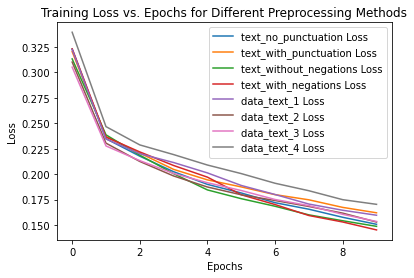

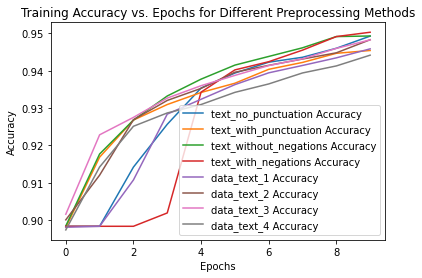

In [133]:

for i, name in enumerate(columnName):
    plt.plot(all_train_loss[i], label=f'{name} Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs for Different Preprocessing Methods')
plt.legend()
plt.savefig(f'Training_Loss_Epochs.png')
plt.show()

for i, name in enumerate(columnName):
    plt.plot(all_train_accuracy[i], label=f'{name} Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Epochs for Different Preprocessing Methods')
plt.legend()
plt.savefig(f'Training_Accuracy.png')
plt.show()

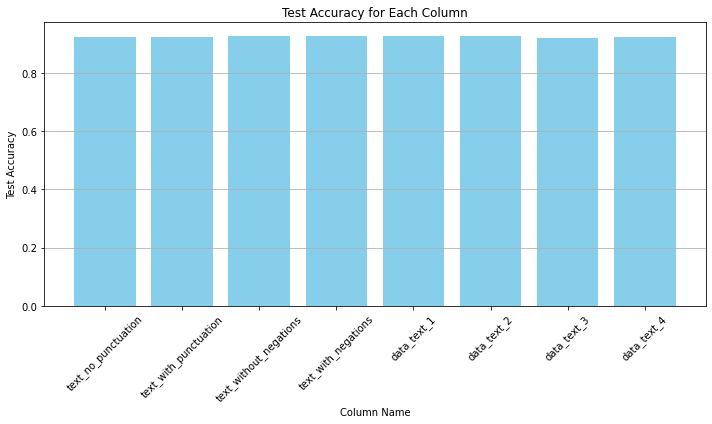

In [136]:
column_names = results_df['Column']
test_accuracy = results_df['Test_Accuracy']

plt.figure(figsize=(10, 6))
plt.bar(column_names, test_accuracy, color='skyblue')
plt.title('Test Accuracy for Each Column')
plt.xlabel('Column Name')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('Test_Accuracy.png')
plt.show()

In [ ]:

columnName = ['text_no_punctuation', 'text_with_punctuation', 'text_without_negations', 
              'text_with_negations', 'data_text_1', 'data_text_2', 'data_text_3', 'data_text_4']

metrics_dict = {'accuracy': [], 'f1-score': [], 'recall': []}
linear_pipeline = make_pipeline(
    TfidfVectorizer(max_features=1000),
    LogisticRegression(solver='sag', max_iter=1000)
)
for name in columnName:
    X_train, y_train, X_test, y_test = datasetDefinition(name)
    linear_pipeline.fit(X_train, y_train)
    y_pred = linear_pipeline.predict(X_test)
    print(name, classification_report(y_test, y_pred))
    metrics_dict['accuracy'].append(classification_report['accuracy_score'])
    metrics_dict['f1-score'].append(classification_report['macro avg']['f1-score'])
    metrics_dict['recall'].append(classification_report['macro avg']['recall'])
    

for metric in metrics_dict.keys():
    plt.figure(figsize=(10, 6))
    plt.bar(columnName, metrics_dict[metric], color='skyblue')
    plt.title(f'{metric.capitalize()} for each Column')
    plt.xlabel('Column Name')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

KeyError: 'text_no_punctuation'